In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import nltk


!pip install scikit-plot


import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import gensim
from gensim.models.doc2vec import Doc2Vec,TaggedDocument

from nltk.corpus import stopwords

### Data Set-Up

In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
Y_train = pd.read_csv('Y_train.csv')
Y_test = pd.read_csv('Y_test.csv')
X_train.shape

(3599999, 3)

### TF-IDF vectorization

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectoriser = TfidfVectorizer()


In [4]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_train.isnull().sum()

Unnamed: 0    0
title         0
text          0
dtype: int64

In [5]:
X_test = X_test.fillna(X_test.mode().iloc[0])
X_test.isnull().sum()

Unnamed: 0    0
title         0
text          0
dtype: int64

In [6]:
tfidf_vectoriser.fit(X_train['text'])
X_train_tf = tfidf_vectoriser.transform(X_train['text'])
X_test_tf = tfidf_vectoriser.transform(X_test['text'])
X_train_tf.shape, X_test_tf.shape                        

((3599999, 2198346), (399999, 2198346))

In [7]:
Y_train = Y_train.drop("Unnamed: 0", axis=1)


In [8]:
Y_test = Y_test.drop("Unnamed: 0", axis=1)


In [9]:
print(f'No. of Features:{X_train_tf.shape[1]}')

No. of Features:2198346


### Naive Bayes

In [10]:
#MultinomialNB
# Build the classifier
multinomial_nb_model = MultinomialNB()

#  Train the classifier
multinomial_nb_model.fit(X_train_tf, np.ravel(Y_train))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
#BernoulliNB
# Build the classifier
bernoulli_nb_model = BernoulliNB()

#  Train the classifier
bernoulli_nb_model.fit(X_train_tf, Y_train)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

### Logistic Regression

In [12]:
pipe = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('logisticregression', LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))])
pipe.fit(X_train_tf, Y_train)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### Linear SVC

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C':[0.5,0.8,1.0]
}
svm = LinearSVC()
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(X_train_tf[:1000], Y_train[:1000])
print("Best Parameters of liner kernal :", svm_cv.best_params_)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters of liner kernal : {'C': 1.0}


In [14]:
linear_svc_model = LinearSVC(**svm_cv.best_params_)
linear_svc_model.fit(X_train_tf, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Decision Trees

In [15]:
#hyper parameter tuning
#importing gridsearchcv
from sklearn.model_selection import GridSearchCV
#giving parameters of decision tree
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

#calling decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)
#applying gridsearchcv for hyper parameter tuning
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
#fitting the data
tree_cv.fit(X_train_tf[:1000], Y_train[:1000])
#to print the best parameters after hyper parameter tuning
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 4038 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 4988 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 6038 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done 7188 tasks      | elapsed: 54.5min
[Parallel(n_jobs=-1)]: Done 8438 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 9788 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-1)]: Done 12996 out of 12996

Best paramters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 9, 'min_samples_split': 2, 'splitter': 'random'})


In [16]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(**best_params)
model_dt.fit(X_train_tf, Y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=16, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

### Random Forest

In [17]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']

# Number of trees in random forest
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid with all parameters defined
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#calling random forest classifier
rand_clf = RandomForestClassifier(random_state=42)
#applying randomised search cv for hyper parameter tuning
rand_cv = RandomizedSearchCV(rand_clf, random_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
#fitting train data using randomised search cv
rand_cv.fit(X_train_tf[:1000], Y_train[:1000])
#to print best parameters after hyper parameter tuning
best_params =rand_cv.best_params_
print(f"Best paramters: {best_params})")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best paramters: {'n_estimators': 311, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True})


In [18]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(**best_params)
model_rf.fit(X_train_tf, Y_train) 


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=311,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Performance Evaluation

### Train data

In [19]:
def report(model,X,Y,modelName,train=True):
    YPred = model.predict(X)
    if train:
        print(f"{modelName} Training Data Result:\n================================================")
    else:
        print(f"{modelName} Test Data Result:\n================================================")
    print(f"Accuracy Score: {accuracy_score(Y, YPred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(Y, YPred)}\n")
    print("_______________________________________________")
    clf_report = pd.DataFrame(classification_report(Y, YPred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    skplt.metrics.plot_confusion_matrix(Y, YPred)

Multinomial NB Model Training Data Result:
Accuracy Score: 84.71%
_______________________________________________
Confusion Matrix: 
 [[1549901  250099]
 [ 300297 1499702]]

_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  8.376947e-01  8.570700e-01  0.847112  8.473824e-01  8.473823e-01
recall     8.610561e-01  8.331682e-01  0.847112  8.471122e-01  8.471122e-01
f1-score   8.492148e-01  8.449501e-01  0.847112  8.470824e-01  8.470824e-01
support    1.800000e+06  1.799999e+06  0.847112  3.599999e+06  3.599999e+06


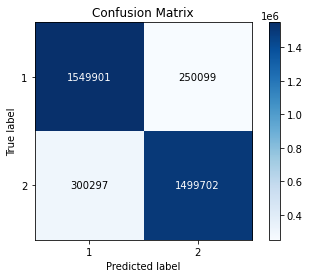

In [20]:
report(multinomial_nb_model,X_train_tf,Y_train,'Multinomial NB Model')

Bernoulli NB Model Training Data Result:
Accuracy Score: 85.25%
_______________________________________________
Confusion Matrix: 
 [[1516008  283992]
 [ 246992 1553007]]

_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  8.599024e-01  8.454044e-01  0.852504  8.526534e-01  8.526534e-01
recall     8.422267e-01  8.627821e-01  0.852504  8.525044e-01  8.525044e-01
f1-score   8.509728e-01  8.540049e-01  0.852504  8.524888e-01  8.524888e-01
support    1.800000e+06  1.799999e+06  0.852504  3.599999e+06  3.599999e+06


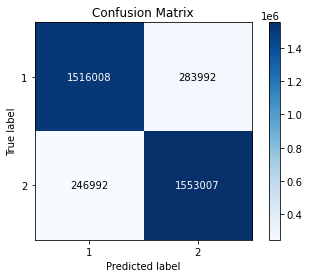

In [21]:
report(bernoulli_nb_model,X_train_tf,Y_train,'Bernoulli NB Model')

Logistic regression Model Training Data Result:
Accuracy Score: 94.10%
_______________________________________________
Confusion Matrix: 
 [[1691519  108481]
 [ 103822 1696177]]

_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  9.421714e-01  9.398883e-01  0.941027  9.410299e-01  9.410299e-01
recall     9.397328e-01  9.423211e-01  0.941027  9.410269e-01  9.410269e-01
f1-score   9.409505e-01  9.411031e-01  0.941027  9.410268e-01  9.410268e-01
support    1.800000e+06  1.799999e+06  0.941027  3.599999e+06  3.599999e+06


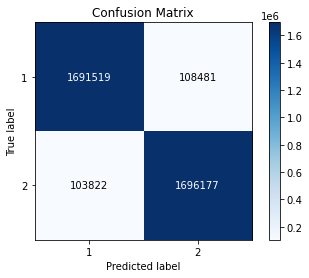

In [22]:
report(pipe,X_train_tf,Y_train,'Logistic regression Model')

Linear SVC Model Training Data Result:
Accuracy Score: 91.71%
_______________________________________________
Confusion Matrix: 
 [[1646972  153028]
 [ 145537 1654462]]

_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  9.188082e-01  9.153367e-01  0.917065  9.170725e-01  9.170725e-01
recall     9.149844e-01  9.191461e-01  0.917065  9.170653e-01  9.170653e-01
f1-score   9.168923e-01  9.172374e-01  0.917065  9.170649e-01  9.170649e-01
support    1.800000e+06  1.799999e+06  0.917065  3.599999e+06  3.599999e+06


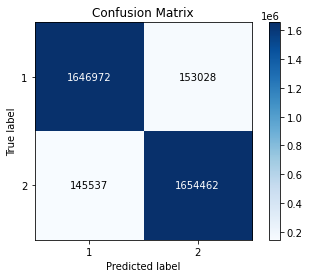

In [23]:
report(linear_svc_model,X_train_tf,Y_train,'Linear SVC Model')

Decision trees Model Training Data Result:
Accuracy Score: 68.82%
_______________________________________________
Confusion Matrix: 
 [[1529762  270238]
 [ 852406  947593]]

_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  6.421722e-01  7.780989e-01  0.688154  7.101356e-01  7.101355e-01
recall     8.498678e-01  5.264408e-01  0.688154  6.881543e-01  6.881544e-01
f1-score   7.315641e-01  6.279963e-01  0.688154  6.797802e-01  6.797802e-01
support    1.800000e+06  1.799999e+06  0.688154  3.599999e+06  3.599999e+06


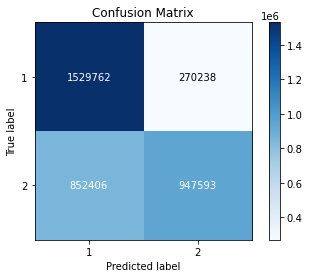

In [24]:
report(model_dt,X_train_tf,Y_train,'Decision trees Model')

Random forest Model Training Data Result:
Accuracy Score: 83.95%
_______________________________________________
Confusion Matrix: 
 [[1448812  351188]
 [ 226787 1573212]]

_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  8.646532e-01  8.175078e-01  0.839451  8.410805e-01  8.410805e-01
recall     8.048956e-01  8.740072e-01  0.839451  8.394514e-01  8.394513e-01
f1-score   8.337049e-01  8.448139e-01  0.839451  8.392594e-01  8.392594e-01
support    1.800000e+06  1.799999e+06  0.839451  3.599999e+06  3.599999e+06


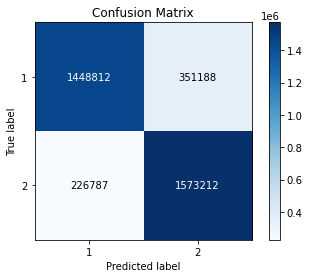

In [ ]:
report(model_rf,X_train_tf,Y_train,'Random forest Model')

### Test Data 

Multinomial NB Model Test Data Result:
Accuracy Score: 82.27%
_______________________________________________
Confusion Matrix: 
 [[167741  32259]
 [ 38649 161350]]

_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy      macro avg  \
precision       0.812738       0.833381   0.82273       0.823059   
recall          0.838705       0.806754   0.82273       0.822730   
f1-score        0.825517       0.819851   0.82273       0.822684   
support    200000.000000  199999.000000   0.82273  399999.000000   

            weighted avg  
precision       0.823059  
recall          0.822730  
f1-score        0.822684  
support    399999.000000  


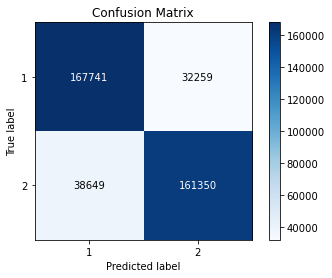

In [ ]:
report(multinomial_nb_model,X_test_tf,Y_test,'Multinomial NB Model',False)

Bernoulli NB Model Test Data Result:
Accuracy Score: 82.97%
_______________________________________________
Confusion Matrix: 
 [[163749  36251]
 [ 31870 168129]]

_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy      macro avg  \
precision       0.837081       0.822629  0.829697       0.829855   
recall          0.818745       0.840649  0.829697       0.829697   
f1-score        0.827812       0.831542  0.829697       0.829677   
support    200000.000000  199999.000000  0.829697  399999.000000   

            weighted avg  
precision       0.829855  
recall          0.829697  
f1-score        0.829677  
support    399999.000000  


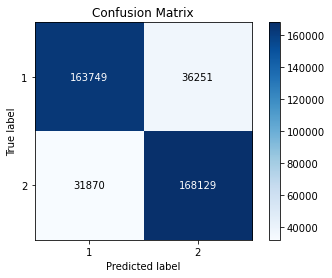

In [ ]:
report(bernoulli_nb_model,X_test_tf,Y_test,'Bernoulli NB Model',False)

Logistic NB Model Test Data Result:
Accuracy Score: 80.16%
_______________________________________________
Confusion Matrix: 
 [[160219  39781]
 [ 39594 160405]]

_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy      macro avg  \
precision       0.801845       0.801280  0.801562       0.801562   
recall          0.801095       0.802029  0.801562       0.801562   
f1-score        0.801470       0.801654  0.801562       0.801562   
support    200000.000000  199999.000000  0.801562  399999.000000   

            weighted avg  
precision       0.801562  
recall          0.801562  
f1-score        0.801562  
support    399999.000000  


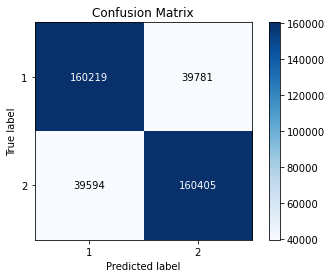

In [ ]:
report(pipe,X_test_tf,Y_test,'Logistic NB Model',False)

Linear SVC Model Test Data Result:
Accuracy Score: 87.12%
_______________________________________________
Confusion Matrix: 
 [[173485  26515]
 [ 25024 174975]]

_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy      macro avg  \
precision       0.873940       0.868405  0.871152       0.871173   
recall          0.867425       0.874879  0.871152       0.871152   
f1-score        0.870670       0.871630  0.871152       0.871150   
support    200000.000000  199999.000000  0.871152  399999.000000   

            weighted avg  
precision       0.871173  
recall          0.871152  
f1-score        0.871150  
support    399999.000000  


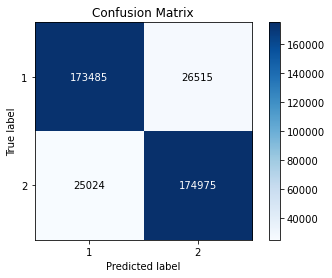

In [ ]:
report(linear_svc_model,X_test_tf,Y_test,'Linear SVC Model',False)

Decision trees Model Training Data Result:
Accuracy Score: 68.81%
_______________________________________________
Confusion Matrix: 
 [[169715  30285]
 [ 94466 105533]]

_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy      macro avg  \
precision       0.642419       0.777018  0.688122       0.709719   
recall          0.848575       0.527668  0.688122       0.688121   
f1-score        0.731245       0.628515  0.688122       0.679880   
support    200000.000000  199999.000000  0.688122  399999.000000   

            weighted avg  
precision       0.709718  
recall          0.688122  
f1-score        0.679880  
support    399999.000000  


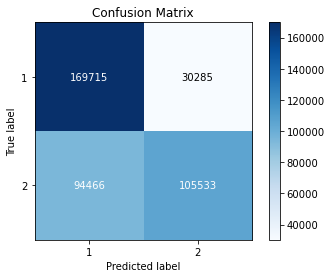

In [ ]:
report(model_dt,X_test_tf,Y_test,'Decision trees Model')

Random Forest Model Training Data Result:
Accuracy Score: 82.72%
_______________________________________________
Confusion Matrix: 
 [[158754  41246]
 [ 27864 172135]]

_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy      macro avg  \
precision       0.850690       0.806703  0.827225       0.828696   
recall          0.793770       0.860679  0.827225       0.827225   
f1-score        0.821245       0.832817  0.827225       0.827031   
support    200000.000000  199999.000000  0.827225  399999.000000   

            weighted avg  
precision       0.828696  
recall          0.827225  
f1-score        0.827031  
support    399999.000000  


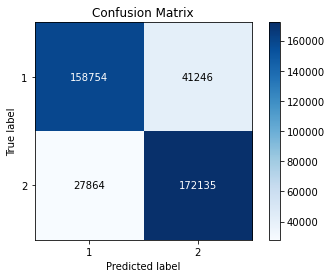

In [ ]:
report(model_rf,X_test_tf,Y_test,'Random Forest Model')

### Doc2Vec


In [ ]:
def feature_extract(dataset):
    data = dataset['title'] + ' ' + dataset['text']
    data = [nltk.word_tokenize(str(l)) for l in data]
    tag_doc = [TaggedDocument(doc, [i]) for i, doc in enumerate(data)]
    model = Doc2Vec(tag_doc)
    return np.array([model.docvecs[i] for i in range(len(model.docvecs))])

train_array = feature_extract(X_train)

In [ ]:
print(f'No. of Features {train_array.shape[1]}')

### Naive Bayes

In [ ]:
#BernoulliNB
# Build the classifier
bernoulli_nb_model = BernoulliNB()

#  Train the classifier
bernoulli_nb_model.fit(train_array, Y_train)

### Logistic Regression

In [ ]:
log_regg = LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000)
log_regg.fit(train_array, Y_train)

### Linear SVC

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C':[0.5,0.8,1.0]
}
svm = LinearSVC()
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(train_array[:50000], Y_train[:50000])
print("Best Parameters of liner kernal :", svm_cv.best_params_)

In [ ]:
linear_svc_model = LinearSVC(**svm_cv.best_params_)
linear_svc_model.fit(train_array, Y_train)

### Decision Trees

In [ ]:
#hyper parameter tuning
#importing gridsearchcv
from sklearn.model_selection import GridSearchCV
#giving parameters of decision tree
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

#calling decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)
#applying gridsearchcv for hyper parameter tuning
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
#fitting the data
tree_cv.fit(train_array[:50000], Y_train[:50000])
#to print the best parameters after hyper parameter tuning
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

In [ ]:
deci_tree = DecisionTreeClassifier(**best_params).fit(train_array,Y_train)

### Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid with all parameters defined
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#calling random forest classifier
rand_clf = RandomForestClassifier(random_state=42)
#applying randomised search cv for hyper parameter tuning
rand_cv = RandomizedSearchCV(rand_clf, random_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
#fitting train data using randomised search cv
rand_cv.fit(train_array[:50000], Y_train[:50000])
#to print best parameters after hyper parameter tuning
best_params =rand_cv.best_params_
print(f"Best paramters: {best_params})")

In [ ]:
rand_forest = RandomForestClassifier(**best_params).fit(train_array,Y_train)

### Performance Evaluation

### Train Data

In [ ]:
report(bernoulli_nb_model,train_array,Y_train,'Bernoulli NB Model')

In [ ]:
report(log_regg,train_array,Y_train,'Logistic Regression Model')

In [ ]:
report(linear_svc_model,train_array,Y_train,'Linear SVC Model',False)

In [ ]:
report(deci_tree,train_array,Y_train,'Decision Tree')

In [ ]:
report(rand_forest,train_array,Y_train,'Random Forest')

### Test Data

In [ ]:

test_array = feature_extract(X_test)

In [ ]:
report(bernoulli_nb_model,test_array,Y_test,'Bernoulli NB Model',False)

In [ ]:
report(log_regg,test_array,Y_test,'Logistic Regression Model',False)

In [ ]:
report(linear_svc_model,test_array,Y_test,'Linear SVC Model',False)

In [ ]:
report(deci_tree,test_array,Y_test,'Decision Tree',False)

In [ ]:
report(rand_forest,test_array,Y_test,'Random Forest',False)